### The Data
We have a real-world dataset from a company that contains information about online purchases. There are 46,152 rows , each of them representing a unique transaction. Specifically, the company operates both a web page and a mobile app, through which users can initiate transactions using any of the following devices;
- desktop (web)
- tablet (web)
- mobile (web)
- android (app)
- ios (app)  


### The Goal: 
The main goal is to provide insights into the performance of different customer segments. Specifically, we will segment users based on the devices they use to make purchases and then investigate different performance metrics to identify which ones must be carefully examined by business stakeholders.

### User Segments
We classify users based on the devices they use to make transactions. We define an audience type for every available device (since we do not have user data for iOS, we have to ignore this audience type). The four audiences will contain single-device users, i.e., users that made transactions only through one device. We also define two multi-device segments: one for users who made transactions using the company's website, utilizing more than one device (desktop, mobile, tablet), and the other multi-device segment is for transactions made through both the website and the company's Android app.

### Workflow
- **Data Cleaning & Transformation**:          
We have created a python script `clean_transform.py` to clean and transform the data. The `transform` function that is provided creates an extra column based on the segment that each user belongs to.


- **Data Analysis**: We explore data to answer questions like;
    - what is the number of transactions per device? 
    - how many users use one device and which device?
    - how many use two or more devices? In this case we break down between 'web' only and how many both  'web' and 'android'.
    - investigate perfomance metrics such as total Revenue, Transactions, Revenue per User, Transactions per User and Revenue per Transaction.


We call the necessary python libraries. We also call `clean_transform.py` to clean and transform data before the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# calling python scripts
from clean_transform import clean, transform

In [2]:
df = pd.read_excel("Cross Device Data.xlsx")
# call functions to clean and transform
df = transform(clean(df))

We allready cleaned and transformed the data by calling `clean_transform.py`. We added an extra column indicating the audience type that each transaction refers to. We will now move forward with the analysis. First, we calculate the number of users and transactions per device category;

In [3]:
print(df.shape)
df.head()

(46152, 8)


,Platform,Device Category,Transaction Id,User Id,Transactions,Revenue,Date,Audience Type
0,web,web:desktop,0585771B-A6E5-472E-ADB9-2941D507F1BE,cc282783-c34c-45a0-a07d-85939d74f33e,1,311,2015-01-01,web only
1,web,web:desktop,089A181B-3958-42AB-B3EC-252BD2F60C82,fb1c429b-6779-4543-8bf6-1eed0286592a,1,166,2015-01-01,web:desktop
2,web,web:desktop,0D3E5CD7-2877-4F11-A769-87249BFBC526,3ab64600-fb99-4e4f-8eb4-4f7a627cf176,1,366,2015-01-01,web:desktop
3,web,web:desktop,15BB13EE-6399-481E-9E5C-A6E3CA71BEEA,9ca2880e-e042-41e6-9ccc-e489e37fe676,1,346,2015-01-01,web:desktop
4,web,web:desktop,17C5CD90-C699-46F5-A533-DF394CCEACA0,6253e7bc-e10b-4587-b5ad-5d3b7e54d37f,1,120,2015-01-01,web:desktop


In [4]:
pvt_device_categories = (df
                         .groupby(by='Device Category')
                         .agg(Users=('User Id', 'nunique'),
                              Transactions=('Transactions', 'sum'))
                         .reset_index()
                        )
pvt_device_categories 

,Device Category,Users,Transactions
0,android,1117,3716
1,ios,0,2663
2,web:desktop,11523,36069
3,web:mobile,1283,2485
4,web:tablet,762,1233


Note: We have been informed that all User Ids for iOS devices are missing. 

Based on the above pivot table it appears that the 'web:desktop' device category is the primary driver of both transaction and user counts. We can show this visually with the following charts;

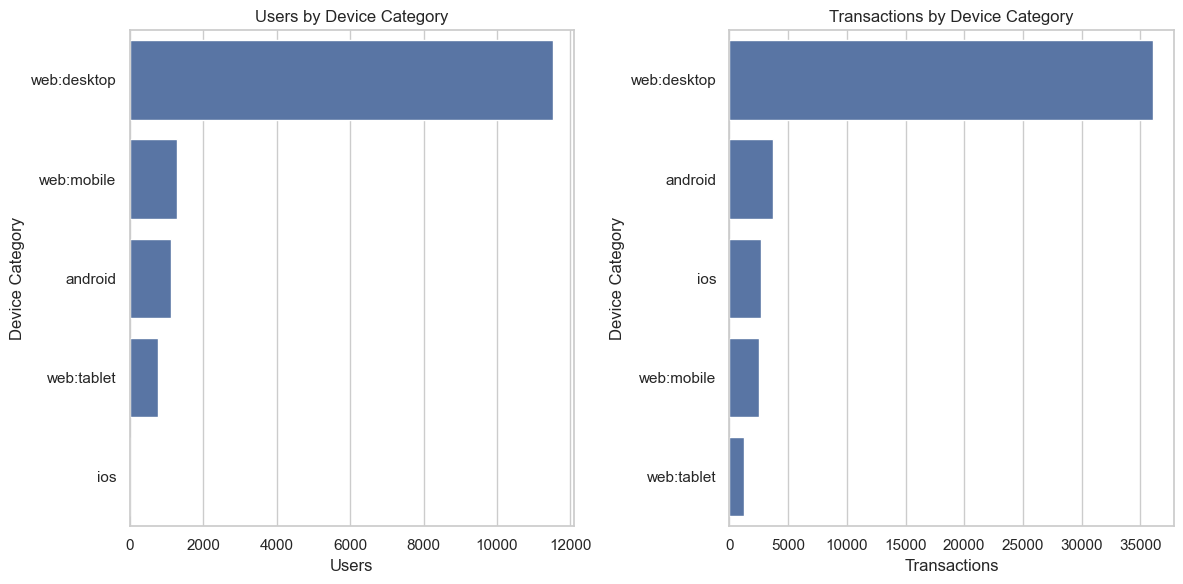

In [5]:
# Users and Transactions by Device Category
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x='Users', y='Device Category', data=pvt_device_categories.sort_values(by='Users', ascending=False), ax=ax[0])
sns.barplot(x='Transactions', y='Device Category', data=pvt_device_categories.sort_values(by='Transactions', ascending=False), ax=ax[1])
ax[0].set_title('Users by Device Category')
ax[1].set_title('Transactions by Device Category')
plt.tight_layout()
plt.show()

It is time to drop 'ios' rows from our DataFrame, since we don't have 'User Id' for 'ios' device category and the goal is to investigate performance of the six semgnets we defined.

In [6]:
df = df[df['Device Category']!='ios']

Moving on, we will now calculate the following:
- How many users use only one device (and which device).
- How many use two or more. In this case we breakdown between 'web' only and how many both 'web' and 'android'. 

In [7]:
pvt_audiences = (df
                 .groupby(by='Audience Type')
                 .agg(Users=('User Id', 'nunique'),
                      Transactions=('Transactions', 'sum'))
                )
pvt_audiences

,Users,Transactions
Audience Type,,
android,561,1268
web & android,556,7071
web only,736,6269
web:desktop,10305,27428
web:mobile,607,848
web:tablet,463,619


The pivot table above can be visualized as follows;

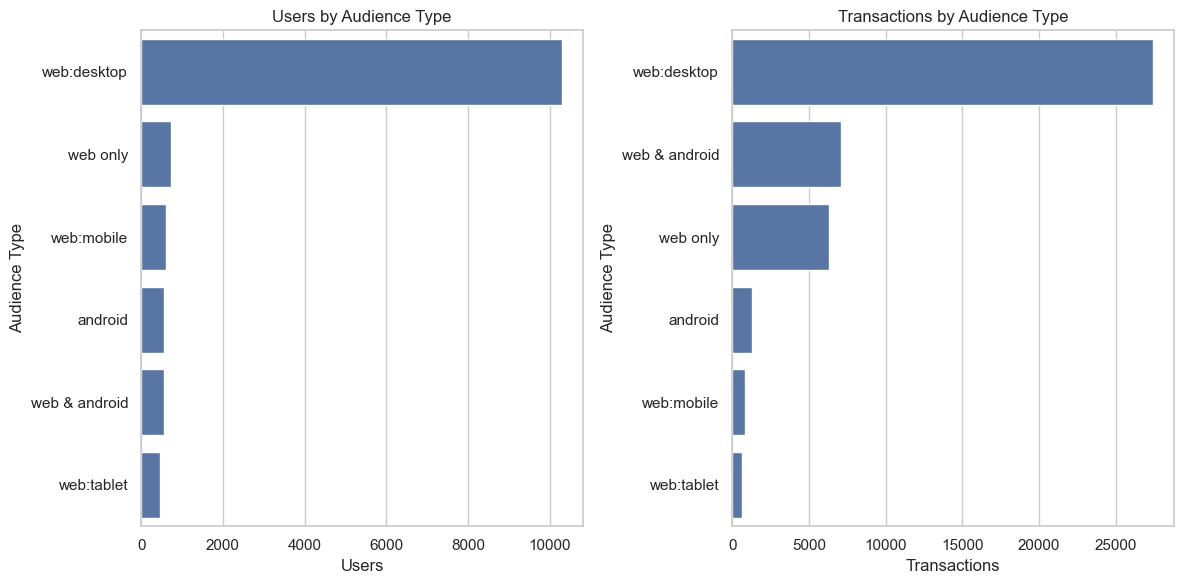

In [8]:
# Users and Transactions by Audience Type
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x='Users', y='Audience Type', data=pvt_audiences.sort_values(by='Users', ascending=False), ax=ax[0])
sns.barplot(x='Transactions', y='Audience Type', data=pvt_audiences.sort_values(by='Transactions', ascending=False), ax=ax[1])
ax[0].set_title('Users by Audience Type')
ax[1].set_title('Transactions by Audience Type')
plt.tight_layout()
plt.show()


We can see that multi-device auidences show a significant number of transactions despite the limited number of users.

We will now procced analyzing the performance of the six audience segments.

Examining revenue distribution is crucial to identify the optimal audience type. It's important to assess whether the average revenue differs across audience types. Some audiences may generate higher revenues due to their users buying more expensive products.

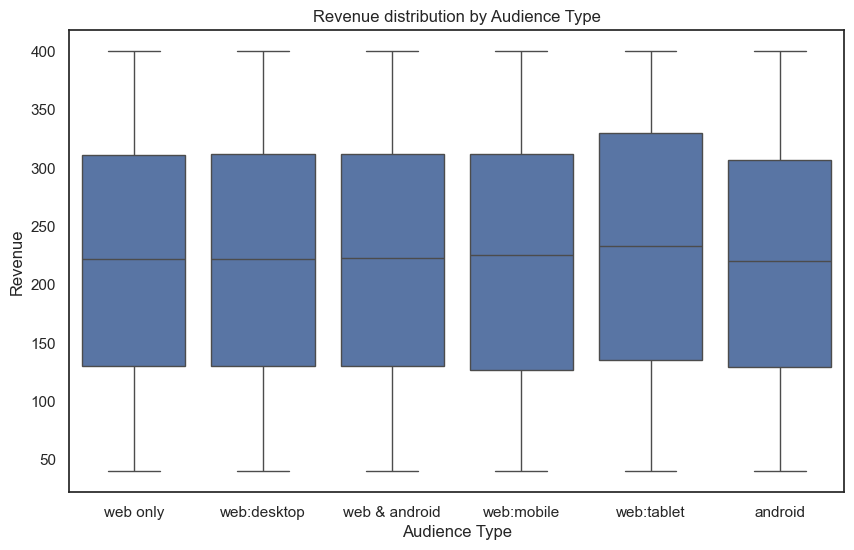

In [9]:
# Filter out rows where Audience Type is not 'Unknown'
filtered_df = df[df['Audience Type'] != 'Unknown']

# Set seaborn style
sns.set(style="white")

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Audience Type', y='Revenue', data=filtered_df)
plt.title('Revenue distribution by Audience Type')
plt.show()

Revenue is uniformly distributed and there are no significant differences between different audience types on average revenue as shown in the box-plot. 
The average revenue produced is rougly the same for each Audience Type. Although this is is obvious from the box-plot, this result can also be confirmed by performing an ANOVA test and getting a p-value greater than the significance level (0.05). 

Performing ANOVA test;

In [10]:
# perform ANOVA test using f_oneway function from SciPy
# f_oneway function will take inputs 'Revenue' columns of each Audience Type
# we use unpack operator *  to unpack  a list of revenue data for each audience type, 
# so that the f_oneway() function can take each revenue data as a separate argument.
F, p = stats.f_oneway(*[df[df['Audience Type']==aud_type]['Revenue'] for aud_type in df['Audience Type'].unique()])

print(f"p = {p:.2f}")
if p < 0.05:
    print('There is a significant difference in revenue among Audience Types.')
else:
    print('There is no significant difference in revenue among Audience types.')

p = 0.31
There is no significant difference in revenue among Audience types.


While revenue is a standard metric for defining performance, we will exclude it from the metrics that determine performance among Audiences.

We have to explore other metrics such as Revenue per User, Transactions per User and Revenue per Transaction.


In [11]:
pvt_audiences = (df
                 .groupby(by='Audience Type')
                 .agg(Users=('User Id', 'nunique'),
                      Transactions=('Transactions', 'sum'),
                     Revenue=('Revenue', 'sum'))
                )
# inlcude Revenue per User
pvt_audiences['Revenue per User'] = pvt_audiences['Revenue'] / pvt_audiences['Users']

# include Transactions per User
pvt_audiences['Transactions per User'] = pvt_audiences['Transactions'] / pvt_audiences['Users']

# include Revenue per Transaction
pvt_audiences['Revenue per Transaction'] = pvt_audiences['Revenue'] / pvt_audiences['Transactions']
pvt_audiences

,Users,Transactions,Revenue,Revenue per User,Transactions per User,Revenue per Transaction
Audience Type,,,,,,
android,561,1268,278021,495.581105,2.260250,219.259464
web & android,556,7071,1563182,2811.478417,12.717626,221.069439
web only,736,6269,1378122,1872.448370,8.517663,219.831233
web:desktop,10305,27428,6063517,588.405337,2.661621,221.070330
web:mobile,607,848,187871,309.507414,1.397035,221.545991
web:tablet,463,619,142492,307.758099,1.336933,230.197092


Revenue per Transaction is the same as mean Revenue.

In [12]:
df.groupby(by='Audience Type')['Revenue'].mean()

Audience Type
android          219.259464
web & android    221.069439
web only         219.866305
web:desktop      221.070330
web:mobile       221.545991
web:tablet       230.197092
Name: Revenue, dtype: float64

This is not surprising because out of 43,502 rows, only one row has two transactions with the same 'Transaction Id'.

In [13]:
df['Transactions'].value_counts()

Transactions
1    43501
2        1
Name: count, dtype: int64

It is shown that the average Revenue is not a metric to use to define the best Audience Type. Thus, the same stands for Revenue per Transaction and we end up with two metrics to investigate, namely Revenue per User and Transactions per User.

In [14]:
pvt_audiences = pvt_audiences.drop(labels='Revenue per Transaction', axis=1)

Since revenue is uniformly distributed among different audience types, we anticipate a strong positive correlation between revenue and tansactions.

Let's examine this relation. To do this we group by User Id and we also include Audience Type information.

In [15]:
df

,Platform,Device Category,Transaction Id,User Id,Transactions,Revenue,Date,Audience Type
0,web,web:desktop,0585771B-A6E5-472E-ADB9-2941D507F1BE,cc282783-c34c-45a0-a07d-85939d74f33e,1,311,2015-01-01,web only
1,web,web:desktop,089A181B-3958-42AB-B3EC-252BD2F60C82,fb1c429b-6779-4543-8bf6-1eed0286592a,1,166,2015-01-01,web:desktop
2,web,web:desktop,0D3E5CD7-2877-4F11-A769-87249BFBC526,3ab64600-fb99-4e4f-8eb4-4f7a627cf176,1,366,2015-01-01,web:desktop
3,web,web:desktop,15BB13EE-6399-481E-9E5C-A6E3CA71BEEA,9ca2880e-e042-41e6-9ccc-e489e37fe676,1,346,2015-01-01,web:desktop
4,web,web:desktop,17C5CD90-C699-46F5-A533-DF394CCEACA0,6253e7bc-e10b-4587-b5ad-5d3b7e54d37f,1,120,2015-01-01,web:desktop
...,...,...,...,...,...,...,...,...
43497,app,android,734C6C67-6299-4BBB-A0C0-2E5F7B30F988,76a2820b-98ac-40cd-b43e-4309b960c3aa,1,380,2016-11-01,android
43498,app,android,8C63395F-9D48-49FB-9000-85AB2646C0A4,5e1b0895-254a-4b5e-8975-0924ee0f0fd1,1,176,2016-11-01,web & android
43499,app,android,8DB89E61-9093-453A-93E4-B1822DD1A50D,57cee173-ddf2-4e3e-991a-35f0ac3bf9e6,1,268,2016-11-01,web & android
43500,app,android,95896ECF-F670-4731-A984-380317CFB39F,7a2bd32a-3d5d-4b25-baf3-166a5b1411f7,1,296,2016-11-01,web & android


In [16]:
group_users_type = (df
        .groupby(by=['User Id', 'Audience Type'])[['Transactions', 'Revenue']]
        .sum()
        .reset_index())

group_users_type

,User Id,Audience Type,Transactions,Revenue
0,0001856c-5489-44a3-b9c6-576ec2c6c4cd,web:desktop,8,1787
1,0005b77a-edcf-458c-9576-ce18c387cae7,web:desktop,1,112
2,0006fdc2-24e3-476b-912c-d5d34b429546,web:desktop,2,383
3,000980bd-fa1c-4340-a045-65a80ebbfbf0,web:desktop,1,174
4,000a2d0b-51e2-40b5-a045-494858094c5c,web:desktop,10,2429
...,...,...,...,...
13223,ffe93c2c-882e-442f-907f-3ab37761a30d,web only,2,667
13224,fff2b13b-2412-4d82-8d6c-9dc5579e08b7,web:mobile,1,230
13225,fffc6f04-4483-413a-a29e-8f5f8ab9ec25,web & android,5,1083
13226,fffe99f0-9acc-4fa9-86c8-3113a3e7a025,web:desktop,6,1118


We can see the linear dependence in the scatter plot below;

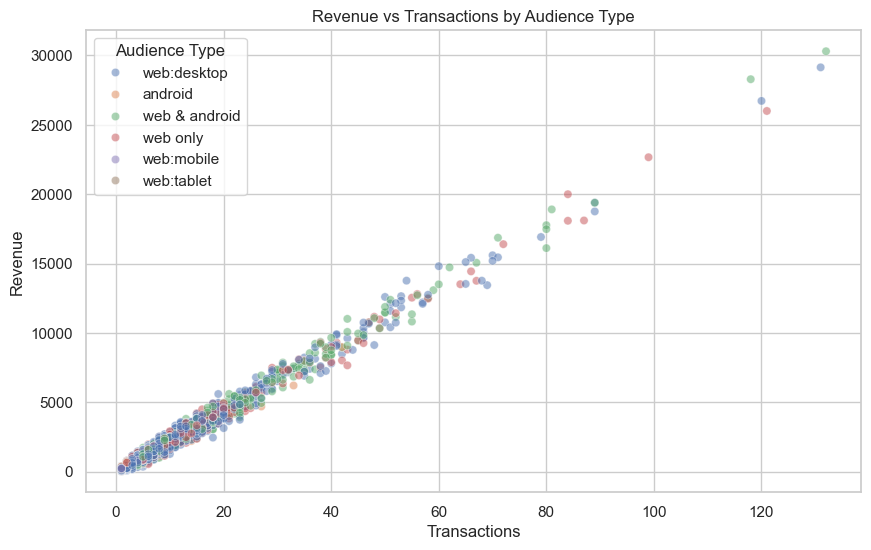

In [17]:
sns.set(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Transactions', y='Revenue', hue='Audience Type', data=group_users_type, alpha=0.5)
plt.title('Revenue vs Transactions by Audience Type')
plt.show()

To obtain a more precise analysis, we can fit a separate line for each Audience Type and calculate the corresponding  Pearson correlation coefficient $r$ for each line.

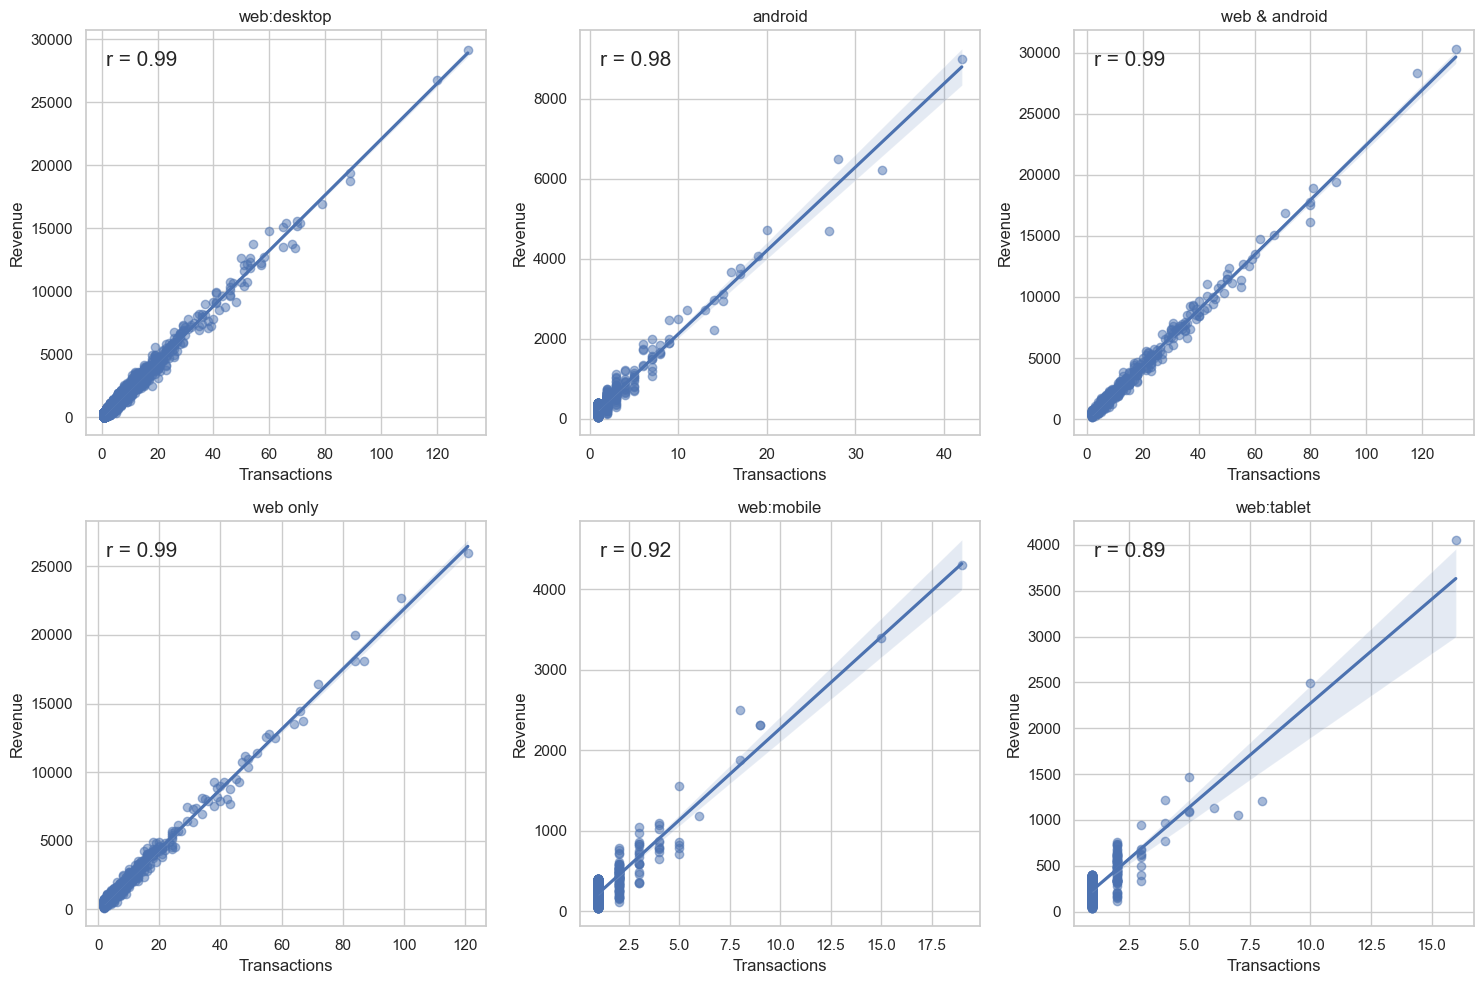

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for i, ele in enumerate(group_users_type['Audience Type'].unique()):
    subset = group_users_type[group_users_type['Audience Type'] == ele]
    sns.regplot(data=subset, x='Transactions', y='Revenue', ax=axs[i])
    axs[i].set_title(ele)
    
    pearson_corr = subset['Transactions'].corr(subset['Revenue'])
    axs[i].text(0.05, 0.95, f"r = {pearson_corr:.2f}",
                 transform=axs[i].transAxes, fontsize=15, va='top')
    axs[i].collections[0].set_alpha(0.5)

plt.tight_layout()
plt.show()

There is a high positive correlation between Revenue and Transactions for every audience type. We can then exclude Transaction per User as a metric for determining performance, leaving us with Revenue per User as the remaining metric.

In [19]:
pvt_audiences = pvt_audiences.drop(labels='Transactions per User', axis=1)
pvt_audiences

,Users,Transactions,Revenue,Revenue per User
Audience Type,,,,
android,561,1268,278021,495.581105
web & android,556,7071,1563182,2811.478417
web only,736,6269,1378122,1872.448370
web:desktop,10305,27428,6063517,588.405337
web:mobile,607,848,187871,309.507414
web:tablet,463,619,142492,307.758099


The only remaining metric is Revenue per User. However, we must also consider the total revenue. This is because although the 'web:desktop' audience has a lower Revenue per User, the number of Users is by far the largest, leading to higher revenue for the company.


To better illustrate the relationship between these metrics and different Audience Types, we have created horizontal bar charts that display the values of each metric for each Audience Type.

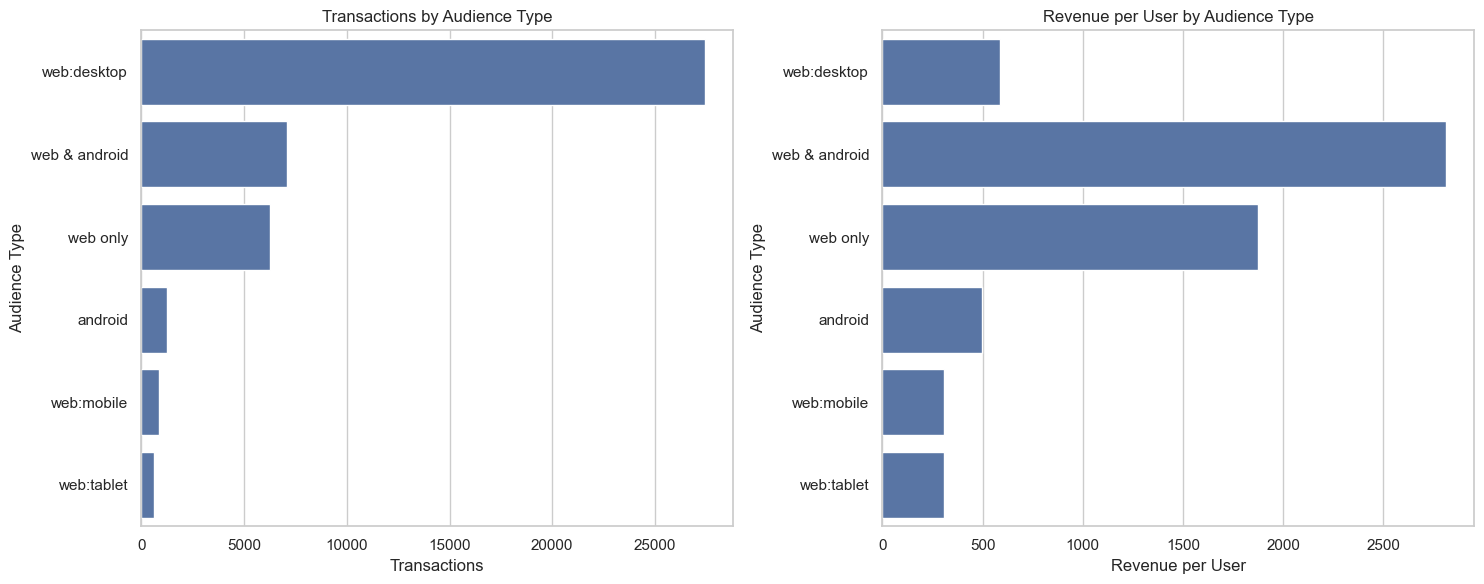

In [20]:
# Create bar charts
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='Transactions', y='Audience Type', data=pvt_audiences.sort_values(by='Transactions', ascending=False), ax=ax[0])
sns.barplot(x='Revenue per User', y='Audience Type', data=pvt_audiences.sort_values(by='Transactions', ascending=False), ax=ax[1])
ax[0].set_title('Transactions by Audience Type')
ax[1].set_title('Revenue per User by Audience Type')
plt.tight_layout()
plt.show()

The provided plots suggest that the 'web & android' and 'web only' audience types have the highest Revenue per User, with rates that are 4.8 and 3.2 times higher, respectively, than that of the 'web:desktop' audience type. However, before drawing any conclusions, we should examine the consistency of Transactions over time for each audience type. To ensure the validity of our conclusions, we need to rule out the possibility that a spike in transactions during a particular period contributed to the higher Revenue per User for the 'web only' and 'web & android' audiences.

Let's investigate Transactions over Time;

In [21]:
group_type_date = (df.groupby(by=['Audience Type', 'Date'])['Transactions']
                   .sum()
                   .reset_index()
                  )

group_type_date.sample(5)

,Audience Type,Date,Transactions
59,web:desktop,2015-05-01,1287
90,web:mobile,2016-01-01,77
47,web only,2016-04-01,376
32,web only,2015-01-01,38
102,web:tablet,2015-02-01,13


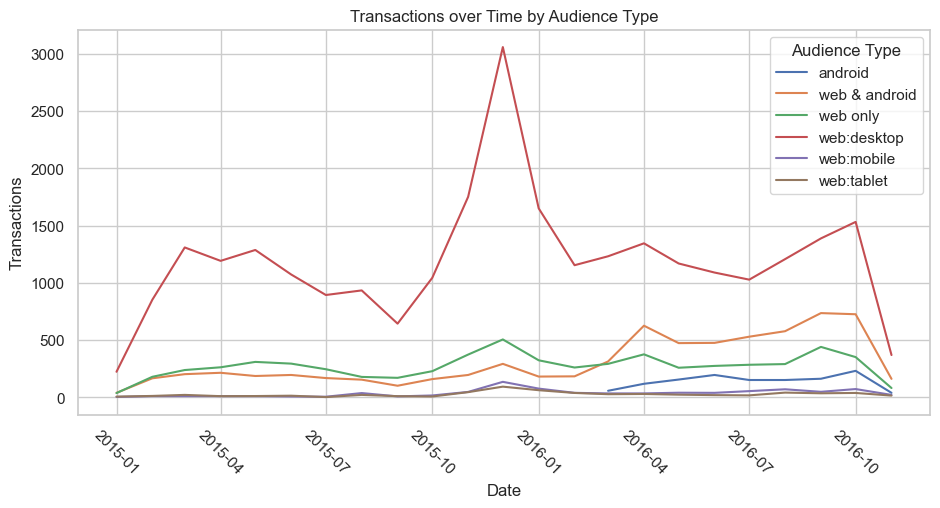

In [22]:
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(11, 5))
sns.lineplot(data=group_type_date, x='Date', y='Transactions', hue='Audience Type')

# Customize the plot
plt.title('Transactions over Time by Audience Type')
plt.xticks(rotation=-45)
plt.xlabel('Date')
plt.ylabel('Transactions')

# Show the plot
plt.show()

We now investigate only "web only" and "web & android" audiences.

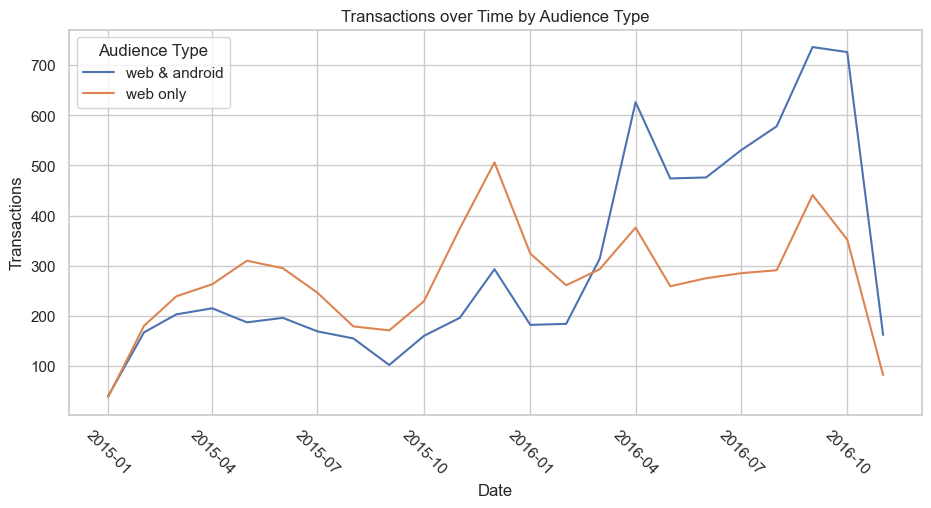

In [23]:
group = group_type_date[(group_type_date['Audience Type'] == 'web only') |
                     (group_type_date['Audience Type'] == 'web & android')]

# Create the line plot
plt.figure(figsize=(11, 5))
sns.lineplot(data=group, x='Date', y='Transactions', hue='Audience Type')

# Customize the plot
plt.title('Transactions over Time by Audience Type')
plt.xticks(rotation=-45)
plt.xlabel('Date')
plt.ylabel('Transactions')

# Show the plot
plt.show()

We can see that the 'web & android' audience had fewer transactions than the 'web only' audience until March 2016. The Transactions made by the 'web & android' audience after this time are responsible for the higher Revenue per User ratio of this group. We must not forget that the 'web & android' audience has slightly fewer users than the 'web only' audience, which makes it even more successful.

Another aspect to consider is the timing of users' first transaction. For instance, businesses may want to determine if changes made to their platform at specific times resulted in the acquisition of new users. To fulfill this purpose, we have created the histogram shown below for multi-device audiences.

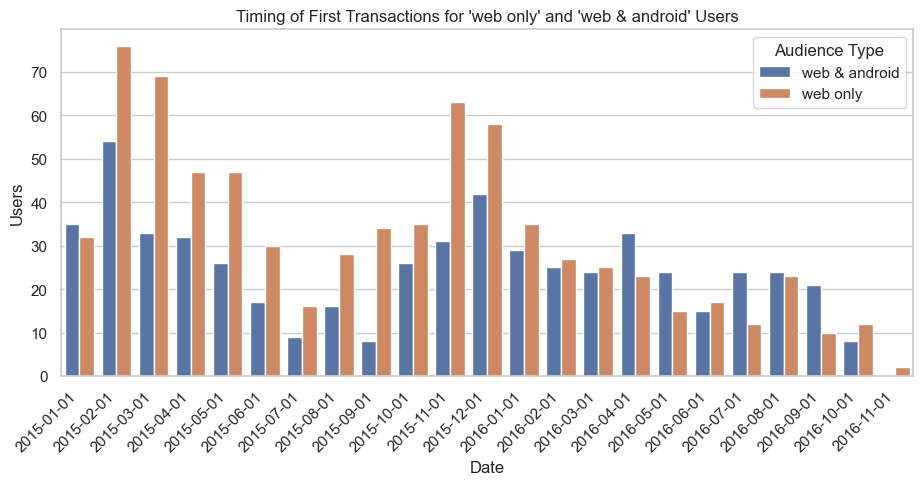

In [24]:
first_date_count = (df[df['Audience Type'].isin(['web only', 'web & android'])]
              .groupby(by=['Audience Type', 'User Id'])['Date']
              .min()
              .reset_index()
              .dropna()
              .groupby(by=['Audience Type', 'Date'])['User Id']
              .count()
              .reset_index()
             )

sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(11, 4.5))
sns.barplot(data=first_date_count, x='Date', y='User Id', hue='Audience Type', dodge=True)

# Customize the plot
plt.title("Timing of First Transactions for 'web only' and 'web & android' Users")
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Users')


# Show the plot
plt.show()

For audience types evolving multiple devices, i.e 'web & android' and 'web only', we want to know the contribution of each device to transactions.

In [25]:
aud_list = ['web & android', 'web only']
type_dev_group = (df[df['Audience Type'].isin(aud_list)]
                     .groupby(by=['Audience Type', 'Device Category'])
                     .agg({'Transactions': 'sum',
                           'Revenue': 'sum',
                           'User Id': 'nunique'})
                     .reset_index()
                     .rename(columns={'User Id': 'Users'})
                     .sort_values(by='Transactions', ascending=False)
                 )

type_dev_group['Revenue per User'] = type_dev_group['Revenue'] / type_dev_group['Users']


type_dev_group

,Audience Type,Device Category,Transactions,Revenue,Users,Revenue per User
4,web only,web:desktop,4382,960134,715,1342.844755
1,web & android,web:desktop,4259,938246,503,1865.300199
0,web & android,android,2448,543421,556,977.375899
5,web only,web:mobile,1336,294086,543,541.594843
6,web only,web:tablet,551,123902,266,465.796992
2,web & android,web:mobile,301,66587,133,500.654135
3,web & android,web:tablet,63,14928,33,452.363636


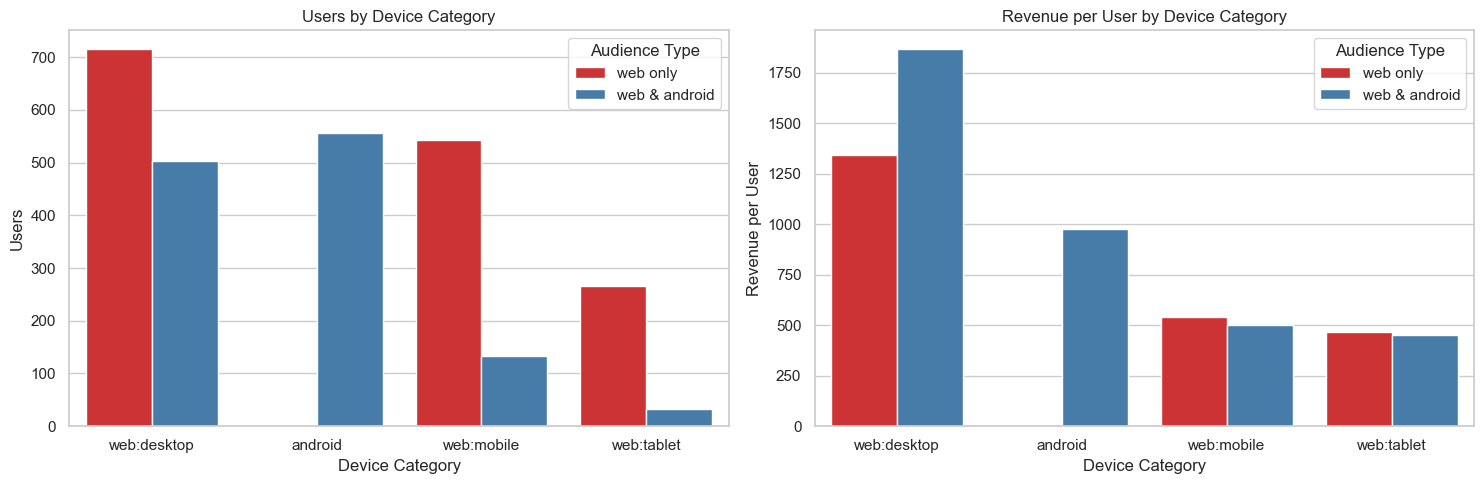

In [26]:
# Set the common color palette
common_palette = sns.color_palette('Set1')[:2]

# Set the style
sns.set(style="whitegrid")

# Create the side-by-side bar plot
plt.figure(figsize=(15, 5))


# Subplot for Revenue
plt.subplot(1, 2, 1)
sns.barplot(data=type_dev_group, x='Device Category', y='Users', hue='Audience Type', palette=common_palette, dodge=True)
plt.title('Users by Device Category')

# Subplot for Revenue per User
plt.subplot(1, 2, 2)
sns.barplot(data=type_dev_group, x='Device Category', y='Revenue per User', hue='Audience Type', palette=common_palette, dodge=True)
plt.title('Revenue per User by Device Category')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### Conclusions

- The average revenue generated by each Audience Type appears to be similar, and there is a very strong positive correlation between revenue per user and transactions per user. Hence, we can explore only revenue per user to assess performance (or transactions per user). Additionally, an increase in transactions will directly result in a proportional increase in revenue.

- Desktop devices account for the majority of transactions and revenue.

- To ensure long-term profitability, we must prioritize user engagement within the 'web only' and 'web & android' audience types. These audiences exhibit significantly higher number of revenue per user.


- Starting from April 2016, the 'web & android' audience outperformed the 'web only' audience, resulting in a higher numer of transactions per user rate.